In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

from bitmexHistoryData import bitmexHistoryBarData, bitmexHistoryTickData

In [32]:
symbol = 'XBTUSD'
startTime = '2018-08-14 11:23:10'
endTime = '2018-08-14 11:24:00'

In [33]:
bm_tick_data = bitmexHistoryTickData(symbol, startTime, endTime)
bm_tick_data.get_history_tick_data()
df = bm_tick_data.data

df = df.set_index(pd.to_datetime(df.timestamp))  # TODO: 写进类里面

df['timestamp_min'] = df.index.values.astype('datetime64[m]')
df['timestamp_sec'] = df.index.values.astype('datetime64[s]')

Getting bitMEX history tick data: XBTUSD, 2018-08-14 11:23:10 ~ 2018-08-14 11:24:00
got page 0 ... last timestamp is 2018-08-14T11:23:59.989Z
Done


In [34]:
#df.head()

In [35]:
#sdf = df[df.timestamp_min == '2018-08-14 07:37:00']
#sdf = df[df.timestamp_sec > '2018-08-14 09:57:21']
sdf = df.copy()
sdf.head(3)

,symbol,timestamp,side,price,size,tickDirection,homeNotional,foreignNotional,grossValue,trdMatchID,timestamp_min,timestamp_sec
timestamp,,,,,,,,,,,,
2018-08-14 11:23:10.687,XBTUSD,2018-08-14T11:23:10.687Z,Sell,6008.0,3000,MinusTick,0.499320,3000,49932000,60ec5cdc-824f-2341-8ca5-a9e396190f95,2018-08-14 11:23:00,2018-08-14 11:23:10
2018-08-14 11:23:11.365,XBTUSD,2018-08-14T11:23:11.365Z,Sell,6008.0,5,ZeroMinusTick,0.000832,5,83220,55c5d94f-c10a-912a-8358-8432e47d2710,2018-08-14 11:23:00,2018-08-14 11:23:11
2018-08-14 11:23:12.939,XBTUSD,2018-08-14T11:23:12.939Z,Sell,6008.0,1000,ZeroMinusTick,0.166440,1000,16644000,722a2851-09a3-7808-7874-00274762c703,2018-08-14 11:23:00,2018-08-14 11:23:12


In [36]:
# plot vlins: by second
seps = sdf.timestamp_sec.unique()

In [37]:
# aggregate by 500ms, calculate net sell/buy
def group_datetime64(s, num, unit):
    order_map = {'m':'h', 's':'m', 'ms':'s'}
    if not isinstance(num, int):
        raise ValueError('num must be int')
    if not unit in order_map.keys():
        raise ValueError('unit must in %s' % order_map.keys())
    upper_unit = order_map[unit]    
    upper_unit_s = s.astype('datetime64[%s]' % upper_unit)
    initial_s = s.astype('datetime64[%s]' % unit)
    return (np.ceil((initial_s - upper_unit_s).astype(int) / num) * num).astype('timedelta64[%s]' % unit) + upper_unit_s

In [38]:
sdf['timestamp_group'] = group_datetime64(sdf.index.values, 500, 'ms')

In [39]:
def aggregate_func(df):
    sell_size = df.loc[df['side'] == 'Sell', 'size'].sum()
    buy_size = df.loc[df['side'] == 'Buy', 'size'].sum()
    netbuy = buy_size - sell_size
    sell_buy_ratio = (buy_size - sell_size) / (sell_size + buy_size)
    return pd.DataFrame([{'buysize': buy_size, 'sellsize': sell_size, 'netbuy': netbuy, 'sbratio': sell_buy_ratio}])

df_throttled = sdf.groupby('timestamp_group').apply(aggregate_func)
df_throttled.reset_index(level=1, drop=True, inplace=True)

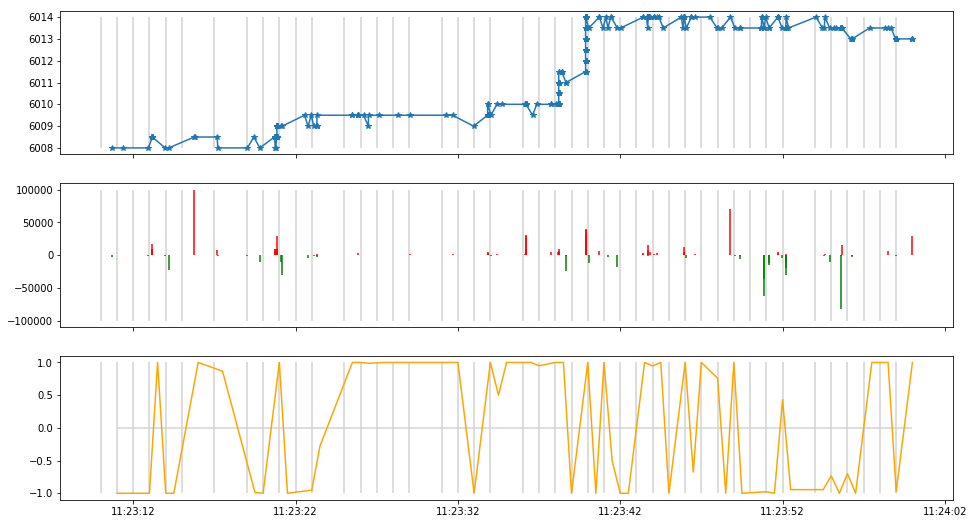

In [40]:
f, ax = plt.subplots(3, sharex=True, figsize=(16,9))

ax[0].plot(sdf.price, '*-')
ax[0].vlines(seps, ymin=sdf.price.min(), ymax=sdf.price.max(), colors='lightgrey')

# ax[1].plot(df_throttled.netbuy, color='orange')
ax[1].vlines(seps, ymin=-sdf['size'].max(), ymax=sdf['size'].max(), colors='lightgrey')

sdf_buy = sdf[sdf.side == 'Buy']
sdf_sell = sdf[sdf.side == 'Sell']
ax[1].vlines(sdf_buy.index.values, ymin=0, ymax=sdf_buy['size'], colors='red')
ax[1].vlines(sdf_sell.index.values, ymin=-sdf_sell['size'], ymax=0, colors='green')

# TODO: group by spread
# sdf_buy['cumsize'] = np.cumsum(sdf_buy['size'])
# sdf_sell['cumsize'] = np.cumsum(sdf_sell['size'])
# ax[2].plot(sdf_buy.cumsize)
# ax[2].plot(sdf_sell.cumsize)

ax[2].plot(df_throttled.sbratio, color='orange')
ax[2].vlines(seps, ymin=-1, ymax=1, colors='lightgrey')
ax[2].hlines(0.0, xmin=df_throttled.index.values.min(), xmax=df_throttled.index.values.max(), colors='lightgrey')

plt.show()